# Iris flower dataset

In [2]:
#Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf #RNN
import graphviz
import pylab as pl
import xgboost
import time

from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier

%matplotlib inline

### 1. Análisis exploratorio de los datos
Exploramos nuestro conjunto de datos.

In [3]:
#Importamos el dataset para iniciar el análisis
iris = pd.read_csv("Iris.csv")
iris=iris.drop(['Id'], axis=1)
feature_names = list(iris.columns[0:-1])
#Visualizamos los primeros 5 datos del dataset
iris.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#Tabla de correlaciones
iris.corr()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


In [5]:
#Resumen estadístico
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Text(0.5, 1.05, 'Distribución de las flores en función de las distintas parejas de variables')

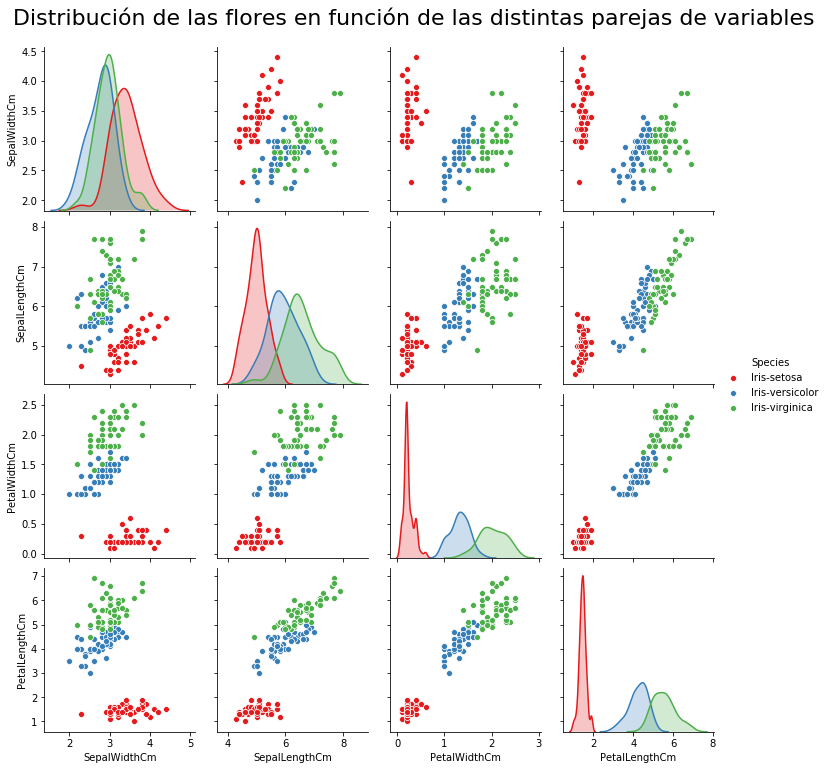

In [6]:
#Representamos el pairplot
g=sns.pairplot(iris,vars=['SepalWidthCm', 'SepalLengthCm', 'PetalWidthCm', 'PetalLengthCm'], hue="Species",palette="Set1")
g.fig.suptitle("Distribución de las flores en función de las distintas parejas de variables", y = 1.05, size = 22)

Representamos las dimensiones del pétalo enfrentadas (Longitud pétalo vs Ancho pétalo) y las dimensiones del sépalo enfrentadas (Longitud sépalo vs Ancho sépalo) para ver si a priori es mejor emplear el pétalo o el sépalo a la hora de clasificar la variedad de iris.

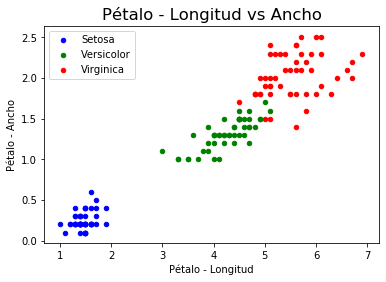

In [7]:
#Grafico Pétalo - Longitud vs Ancho
fig = iris[iris.Species == "Iris-setosa"].plot(kind='scatter', x='PetalLengthCm', y='PetalWidthCm', color='blue', label='Setosa')
iris[iris.Species == "Iris-versicolor"].plot(kind='scatter', x='PetalLengthCm', y='PetalWidthCm', color='green', label='Versicolor', ax=fig)
iris[iris.Species == "Iris-virginica"].plot(kind='scatter', x='PetalLengthCm', y='PetalWidthCm', color='red', label='Virginica', ax=fig)
fig.set_xlabel('Pétalo - Longitud')
fig.set_ylabel('Pétalo - Ancho')
fig.set_title('Pétalo - Longitud vs Ancho', fontsize = 16.5)
plt.show()

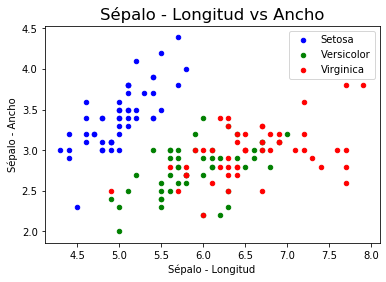

In [8]:
#Grafico Sépalo - Longitud vs Ancho
fig = iris[iris.Species == "Iris-setosa"].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='blue', label='Setosa')
iris[iris.Species == "Iris-versicolor"].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='green', label='Versicolor', ax=fig)
iris[iris.Species == "Iris-virginica"].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='red', label='Virginica', ax=fig)
fig.set_xlabel('Sépalo - Longitud')
fig.set_ylabel('Sépalo - Ancho')
fig.set_title('Sépalo - Longitud vs Ancho', fontsize = 16.5)
plt.show()

### 2. Preparación conjuntos train y test

Dividimos el dataset en dos arrays: X (características) e Y (etiquetas) y aplicaremos la siguiente correspondencia: 

- Iris-setosa corresponde a 0
- Iris-versicolor corresponde a 1 
- Iris.virginica corresponde a 2

In [9]:
#Reproducibilidad, establecemos una semilla
seed = 887
#Estandarizamos nuestros datos numéricos
scaler=StandardScaler()
fitted=scaler.fit(iris.iloc[:,0:4])
#Separamos las variables independientes estandarizadas
X = scaler.transform(iris.iloc[:,:4])
#Aplicamos la correspondencia de números a las etiquetas
iris = iris.replace({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2})
#Separamos la variable dependiente
Y = iris.iloc[:,-1]
#Creamos los subconjuntos train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)


### 3. Aplicación de modelos de comparación

#### 3.1. Random forest

In [10]:
#Creamos el modelo
RF_model = RandomForestClassifier()
#Valores para el parámetro de profundidad máxima del árbol max_depth
max_depths = np.arange(6,13)
#Valores para el número de árboles n_estimators
n_estimators = [10, 50, 100, 200]
#Agrupamos la "rejilla" que integrará todas las combinaciones posibles de hiperparámetros
param_grid = { 'max_depth': max_depths, 'n_estimators': n_estimators }
#Entrenamos un modelo para cada combinación posible de hiperparámetros con 4 particiones estratificadas (cv = 4)
start = time.time()
grid_RF = GridSearchCV(estimator = RF_model,
                    param_grid = param_grid,
                    cv = 4,
                    return_train_score=True)
#Entrenamos los modelos
grid_RF.fit(X_train, Y_train)
end = time.time()
#Mostramos el mejor resultado de validación cruzada y los hiperparámetros que lo han generado
print("Best cross-validation score:", grid_RF.best_score_)
print("Best parameters: ", grid_RF.best_params_)
#Representamos el heatmap creando un dataframe
print("Heatmap Random Forest.")
pvt_RF = pd.pivot_table(pd.DataFrame(grid_RF.cv_results_),
                     values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
#heatm_RF = sns.heatmap(pvt_RF)
print("Tiempo de ajuste:", round(end - start, 3))

Best cross-validation score: 0.9500000000000001
Best parameters:  {'max_depth': 6, 'n_estimators': 10}
Heatmap Random Forest.
Tiempo de ajuste: 14.312


In [11]:
#Entrenamos el modelo con el mejor set de hiperparámetros
start = time.time()
RF_model = RandomForestClassifier(n_estimators=grid_RF.best_params_["n_estimators"], max_depth=grid_RF.best_params_["max_depth"])
RF_model.fit(X_train, Y_train)
end = time.time()
#Calculamos su precisión
print("Precisión entrenamiento del Random Forest:", RF_model.score(X_train, Y_train))
print("Precisión del Random Forest:", RF_model.score(X_test, Y_test))
print("Tiempo de ejecución:", round(end - start, 3))

Precisión entrenamiento del Random Forest: 0.9833333333333333
Precisión del Random Forest: 0.9666666666666667
Tiempo de ejecución: 0.017


In [12]:
#Extraemos y mostramos la importancia de atributos
RF_importances = RF_model.feature_importances_
for i,v in enumerate(RF_importances):
    print('Feature:', feature_names[i], 'Score:', round(v,4))

Feature: SepalLengthCm Score: 0.1545
Feature: SepalWidthCm Score: 0.0305
Feature: PetalLengthCm Score: 0.4495
Feature: PetalWidthCm Score: 0.3655


Text(0.5, 1.0, 'Dataset Iris | Relevancia de atributos | Random Forest')

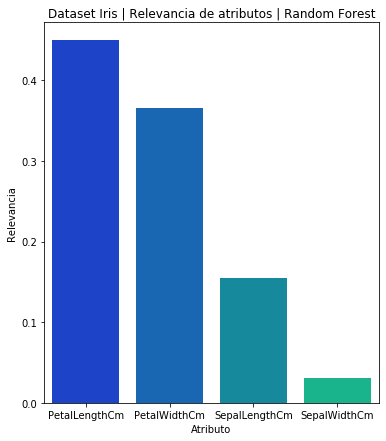

In [13]:
#Representamos en un diagrama de barras la relevancia de atributos
RF_feature_importance = pd.DataFrame({'Atributo':feature_names, 'Relevancia':RF_importances})
RF_feature_importance = RF_feature_importance.sort_values(by='Relevancia', ascending=False).reset_index()

plt.figure(figsize=[6,7])
sns.barplot(y='Relevancia', x='Atributo', data=RF_feature_importance[:14], palette="winter")
plt.title('Dataset Iris | Relevancia de atributos | Random Forest', fontsize=12)


#### 3.2. GradientBoosting

In [14]:
#Creamos el modelo
GB_model = GradientBoostingClassifier()
#Valores para el parámetro de profundidad máxima del árbol max_depth
max_depths = np.arange(6,13)
#Valores para el número de árboles n_estimators
n_estimators = [10, 50, 100, 200]
#Agrupamos la "rejilla" que integrará todas las combinaciones posibles de hiperparámetros
param_grid = { 'max_depth': max_depths, 'n_estimators': n_estimators }
#Entrenamos un modelo para cada combinación posible de hiperparámetros con 4 particiones estratificadas (cv = 4)
start = time.time()
grid_GB = GridSearchCV(estimator = GB_model,
                    param_grid = param_grid,
                    cv = 4,
                    return_train_score=True)
#Entrenamos los modelos
grid_GB.fit(X_train, Y_train)
end = time.time()
#Mostramos el mejor resultado de validación cruzada y los hiperparámetros que lo han generado
print("Best cross-validation score:", grid_GB.best_score_)
print("Best parameters: ", grid_GB.best_params_)
#Representamos el heatmap creando un dataframe
print("Heatmap Random Forest.")
pvt_GB = pd.pivot_table(pd.DataFrame(grid_GB.cv_results_),
                     values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
#heatm_GB = sns.heatmap(pvt_GB)
print("Tiempo de ajuste:", round(end - start, 3))

Best cross-validation score: 0.9416666666666667
Best parameters:  {'max_depth': 6, 'n_estimators': 50}
Heatmap Random Forest.
Tiempo de ajuste: 21.984


In [15]:
#Entrenamos el modelo con el mejor set de hiperparámetros
start = time.time()
GB_model = GradientBoostingClassifier(learning_rate = 0.01, max_depth=grid_GB.best_params_["max_depth"], n_estimators=grid_GB.best_params_["n_estimators"])
GB_model.fit(X_train, Y_train)
end = time.time()
#Calculamos su precisión
print("Precisión entrenamiento del Gradient Boosting:", GB_model.score(X_train, Y_train))
print("Precisión del Gradient Boosting:", GB_model.score(X_test, Y_test))
print("Tiempo de ejecución:", round(end - start, 3))

Precisión entrenamiento del Gradient Boosting: 1.0
Precisión del Gradient Boosting: 0.9666666666666667
Tiempo de ejecución: 0.139


In [16]:
#Extraemos y mostramos la importancia de atributos
GB_importances = GB_model.feature_importances_
for i,v in enumerate(GB_importances):
    print('Feature:', feature_names[i], 'Score:', round(v,4))

Feature: SepalLengthCm Score: 0.014
Feature: SepalWidthCm Score: 0.0186
Feature: PetalLengthCm Score: 0.2613
Feature: PetalWidthCm Score: 0.7062


Text(0.5, 1.0, 'Dataset Iris | Relevancia de atributos | Gradient Boosting')

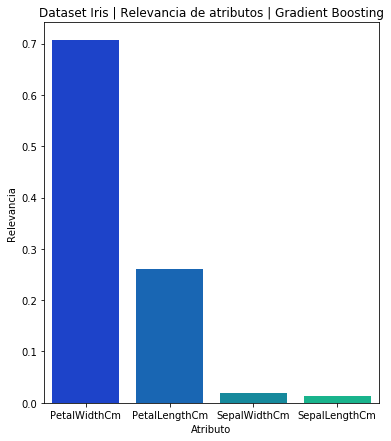

In [17]:
#Representamos en un diagrama de barras la relevancia de atributos
GB_feature_importance = pd.DataFrame({'Atributo':feature_names, 'Relevancia':GB_model.feature_importances_})
GB_feature_importance = GB_feature_importance.sort_values(by='Relevancia', ascending=False).reset_index()

plt.figure(figsize=[6,7])
sns.barplot(x='Atributo', y='Relevancia', data=GB_feature_importance, palette="winter")
plt.title('Dataset Iris | Relevancia de atributos | Gradient Boosting')

### 4. Red neuronal MLP Classifier

In [19]:
#Importamos el dataset para iniciar el análisis
iris = pd.read_csv("Iris.csv")
iris=iris.drop(['Id'], axis=1)
feature_names = list(iris.columns[0:4,])
#Reproducibilidad, establecemos una semilla
seed = 888
#Estandarizamos nuestros datos numéricos
scaler=StandardScaler()
fitted=scaler.fit(iris.iloc[:,0:4])
X = iris.iloc[:,:4]
#Separamos las variables independientes estandarizadas
#X = scaler.transform(iris.iloc[:,:4])
#Aplicamos la correspondencia de números a las etiquetas
#Separamos la variable dependiente
#Usamos el OneHotEncoder para codificar las características enteras en un vector_One-hot
from sklearn.preprocessing import OneHotEncoder
Y = iris.iloc[:,-1]
OHE=OneHotEncoder(sparse=False)
reshaped=Y.values.reshape(len(Y), 1)
y_OH=OHE.fit_transform(reshaped)
#Creamos los subconjuntos train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_OH, test_size=0.2, random_state=seed)
X = pd.DataFrame(data=X, columns=feature_names)
X_train = pd.DataFrame(data=X_train, columns=feature_names)
X_test = pd.DataFrame(data=X_test, columns=feature_names)

In [23]:
start = time.time()
MLP_model = MLPClassifier(solver='lbfgs', max_iter = 1000, alpha=1e-1, hidden_layer_sizes=(5, 5, 2), random_state=0)
MLP_model.fit(X_train, Y_train)
end = time.time()
print("Precisión entrenamiento del MLP Classifier:", MLP_model.score(X_train, Y_train))
print("Precisión del MLP Classifier:", MLP_model.score(X_test, Y_test))
print("Tiempo de ejecución:", round(end - start, 3))

Precisión entrenamiento del MLP Classifier: 1.0
Precisión del MLP Classifier: 0.9333333333333333
Tiempo de ejecución: 0.473


### 5. Aplicación SHAP values

In [24]:
#Importamos la librería SHAP
import shap
#Cargamos el código de visualización JS en el cuaderno de Jupyter
shap.initjs()

In [25]:
#Calculamos el explicador
explainer = shap.KernelExplainer(MLP_model.predict_proba, X)
#Calculamos las SHAP values
shap_values = explainer.shap_values(X)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [27]:
#Sumamos las importancias SHAP para las distintas clases
SHAP_importances = np.abs(shap_values[0]).mean(0) + np.abs(shap_values[1]).mean(0) + np.abs(shap_values[2]).mean(0)

Text(0.5, 1.0, 'Dataset Iris | Relevancia de atributos | SHAP')

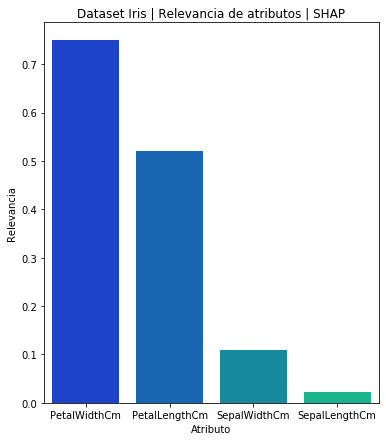

In [28]:
#Representamos en un diagrama de barras la relevancia de atributos
SHAP_feature_importance = pd.DataFrame({'Atributo':feature_names, 'Relevancia':SHAP_importances})
SHAP_feature_importance = SHAP_feature_importance.sort_values(by='Relevancia', ascending=False).reset_index()

plt.figure(figsize=[6,7])
sns.barplot(x='Atributo', y='Relevancia', data=SHAP_feature_importance, palette="winter")
plt.title('Dataset Iris | Relevancia de atributos | SHAP')

### Comparativa de modelos

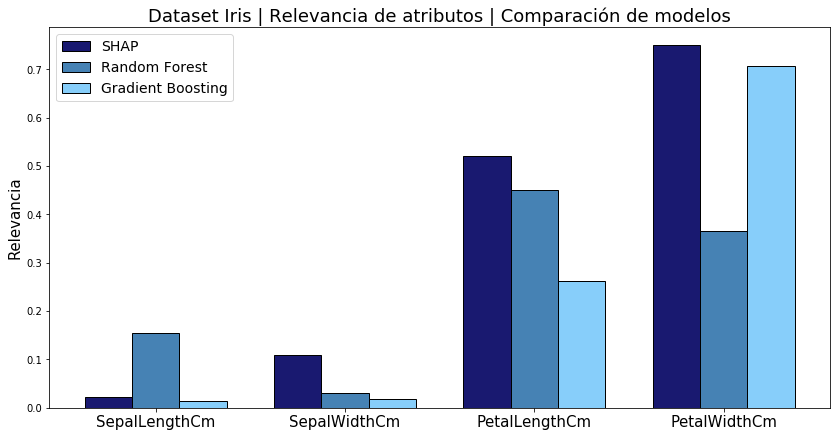

In [31]:
#Representamos la relevancia de características para los tres modelos
labels =  [ i for i in feature_names]


x = np.arange(len(labels))
width = 0.5


fig, ax = plt.subplots(figsize=(14,7))
rects1 = ax.bar(x - width/2, SHAP_importances, width/2, label='SHAP', color='midnightblue',  edgecolor = 'black')
rects2 = ax.bar(x, RF_importances, width/2, label='Random Forest', color='steelblue',  edgecolor = 'black')
rects3 = ax.bar(x  + width/2 , GB_importances, width/2, label='Gradient Boosting', color='lightskyblue',  edgecolor = 'black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relevancia', fontsize = 15)
ax.set_title('Dataset Iris | Relevancia de atributos | Comparación de modelos', fontsize = 18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(fontsize = 14)

### Summary plot

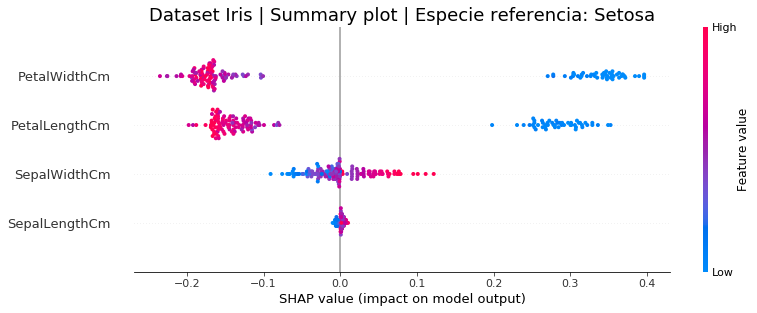

In [31]:
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.set_title('Dataset Iris | Summary plot | Especie referencia: Setosa', fontsize = 18)
shap.summary_plot(shap_values[0], X, plot_size=None)

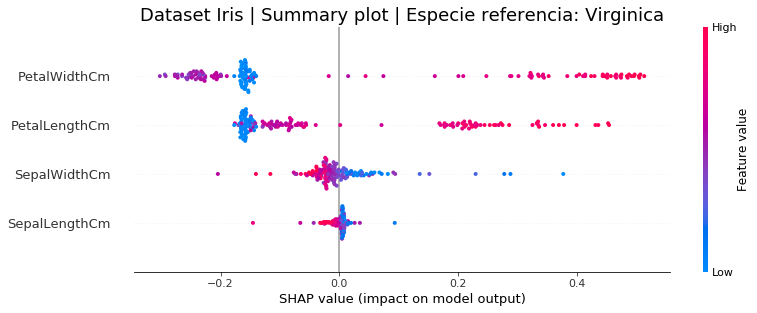

In [32]:
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.set_title('Dataset Iris | Summary plot | Especie referencia: Virginica', fontsize = 18)
shap.summary_plot(shap_values[2], X, plot_size=None)

### Dependence plot

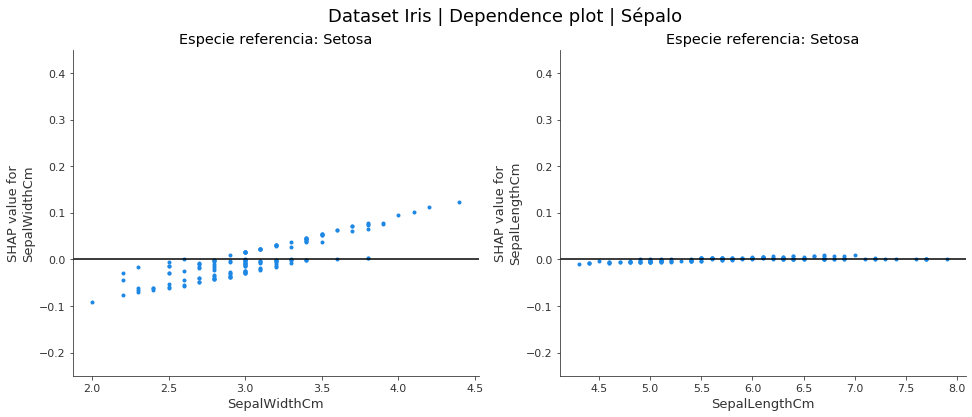

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('Dataset Iris | Dependence plot | Sépalo', fontsize = 18)
axes[0].set_title('Especie referencia: Setosa', fontsize = 14.5)
axes[1].set_title('Especie referencia: Setosa', fontsize = 14.5)
axes[0].set_ylim([-0.25,0.45])
axes[1].set_ylim([-0.25,0.45])
axes[0].axhline(y = 0, color = 'black')
axes[1].axhline(y = 0, color = 'black')
shap.dependence_plot("SepalWidthCm", shap_values[0], X, ax=axes[0], show=False, interaction_index=None)
shap.dependence_plot("SepalLengthCm", shap_values[0], X, ax=axes[1], show=False, interaction_index=None)
plt.show()

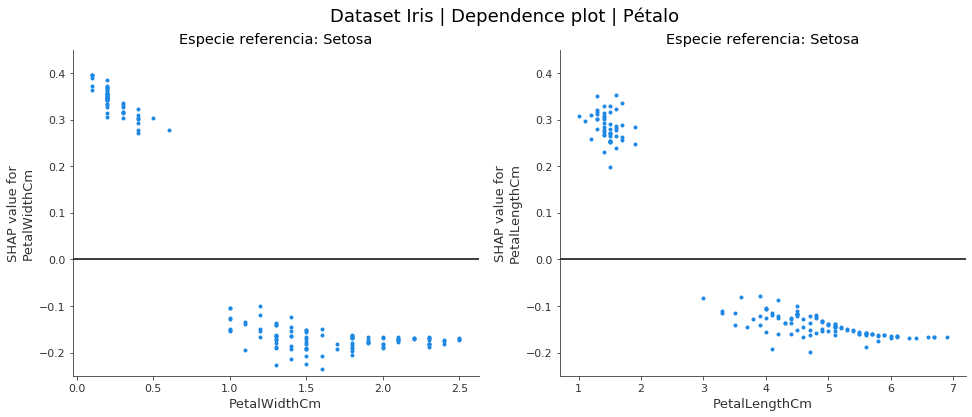

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('Dataset Iris | Dependence plot | Pétalo', fontsize = 18)
axes[0].set_title('Especie referencia: Setosa', fontsize = 14.5)
axes[1].set_title('Especie referencia: Setosa', fontsize = 14.5)
axes[0].set_ylim([-0.25,0.45])
axes[1].set_ylim([-0.25,0.45])
axes[0].axhline(y = 0, color = 'black')
axes[1].axhline(y = 0, color = 'black')
shap.dependence_plot("PetalWidthCm", shap_values[0], X, ax=axes[0], show=False, interaction_index=None)
shap.dependence_plot("PetalLengthCm", shap_values[0], X, ax=axes[1], show=False, interaction_index=None)
plt.show()

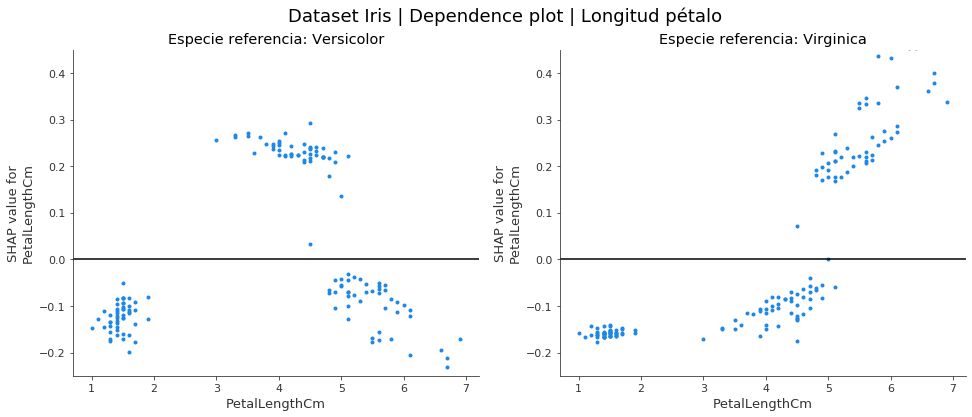

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('Dataset Iris | Dependence plot | Longitud pétalo', fontsize = 18)
axes[0].set_title('Especie referencia: Versicolor', fontsize = 14.5)
axes[1].set_title('Especie referencia: Virginica', fontsize = 14.5)
axes[0].set_ylim([-0.25,0.45])
axes[1].set_ylim([-0.25,0.45])
axes[0].axhline(y = 0, color = 'black')
axes[1].axhline(y = 0, color = 'black')
shap.dependence_plot("PetalLengthCm", shap_values[1], X, ax=axes[0], show=False, interaction_index=None)
shap.dependence_plot("PetalLengthCm", shap_values[2], X, ax=axes[1], show=False, interaction_index=None)
plt.show()

### Individual force plot

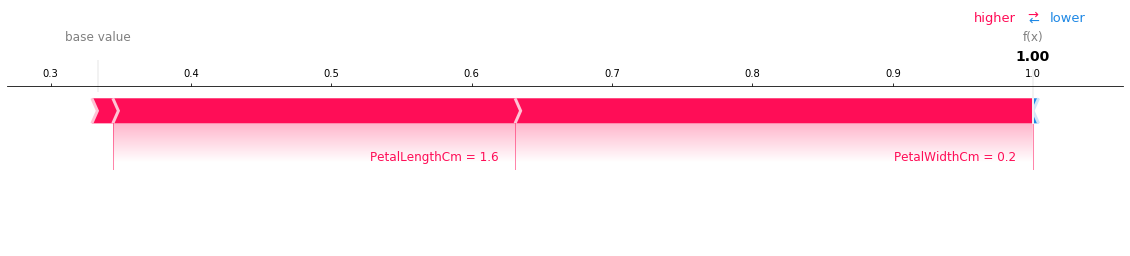

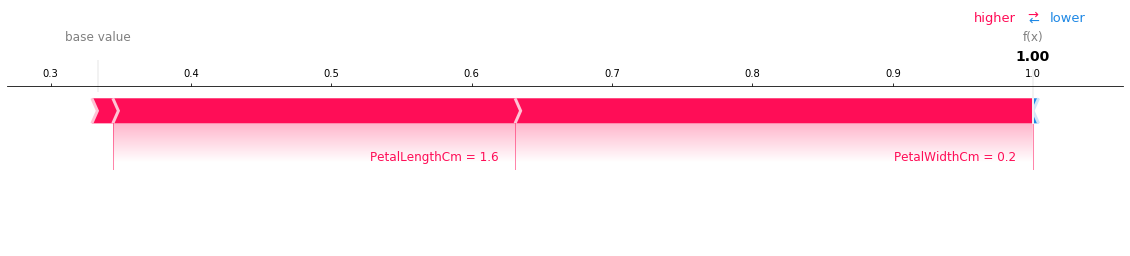

In [36]:
shap_values = explainer.shap_values(X.iloc[25,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X.iloc[25,:], show=False, matplotlib=True)

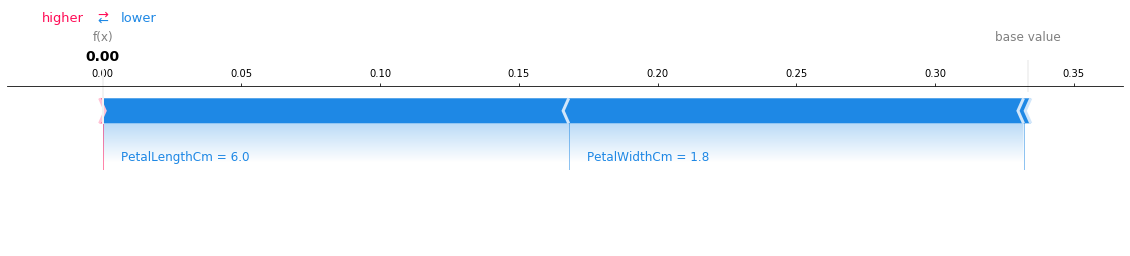

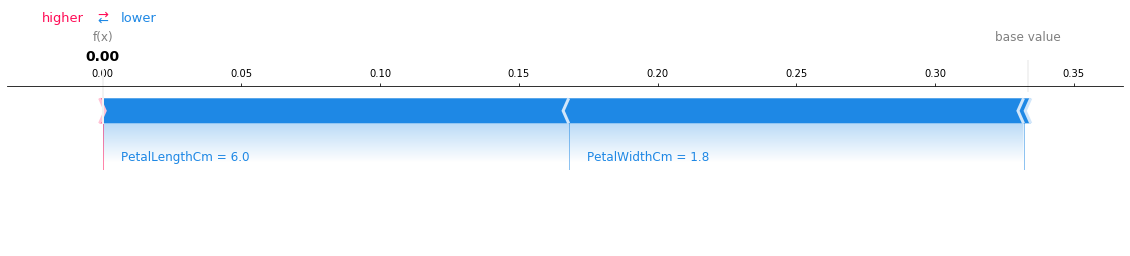

In [37]:
shap_values = explainer.shap_values(X.iloc[125,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X.iloc[125,:], show=False, matplotlib=True)

### Collective force plot

In [38]:
shap_values = explainer.shap_values(X)

In [39]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X, show=False)

In [40]:
#En este caso será necesario guardar el plot como html
f=shap.force_plot(explainer.expected_value[0], shap_values[0], X, show=False)
shap.save_html("index.htm", f)

In [41]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

In [ ]:
f2 = shap.force_plot(explainer.expected_value[2], shap_values[2], X)
shap.save_html("index2.htm", f2)